## This model version is used to train data from a glyphosate using data from the Hammamatsu spec sensor.
### Input data = 100 (50 dispersion + 50 emission)

In [1]:
# Import modules
import os

# --- Step 1: Force CPU Usage (MUST be first) ---
# This ensures deterministic computations by avoiding the MPS GPU backend.
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
import numpy as np
import random

# --- Step 2: Set All Random Seeds ---
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

print("Forcing CPU-only execution for reproducibility. ✅")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler, RobustScaler
# from tensorflow.keras.callbacks import EarlyStopping

import csv
# Misc
# from itertools import islice
# import plotly.express as px

Forcing CPU-only execution for reproducibility. ✅
Num GPUs Available:  0


### Read main file with samples

In [2]:
# Create augmentations with original data

# File path with measurements 
#file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/all_samples.csv'
#file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/all_samples_backup.csv'
file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/sep17v2.csv'

# Open file with data. Extract first 19 elements in each row
with open(file_path, 'r') as file:
    reader = csv.reader(file)
    n = 0
    data = []
    for i,row in enumerate(reader):
        data.append(row)
        # if n<1015:
        #     data.append(row)
        # n+=1
#len(data)

split = []
split.append(len(data)) # original samples
split.append(len(data)*0.9) # train and val set
split.append((len(data)*0.2)/(len(data)*0.9)) # val set percentage
split.append(len(data)*0.1) # test set

# Shuffle the rows of the data list in-place
random.shuffle(data)

print(len(data))
print(split)


56
[56, 50.4, 0.22222222222222224, 5.6000000000000005]


### Review structure

In [ ]:
import matplotlib.pyplot as plt
#print(len(data),len(data[0]))
y_data = []
for i,y_i in enumerate(data): 
    y_row = []
    #print(len(y_i))
    for j in y_i[3:]:
        #print(j)
        if j != '-':
            y_row.append(float(j))
    y_data.append(y_row)
    
#print(len(y_data[0]))
x_data = np.linspace(400,950,len(y_data[0]))
#print(len(x_data))

plt.figure(figsize=(10, 10))
prev_cc = y_data[0][1]
b_color = 0.0
r_color = 1.0
for i in range(len(data)):
    cc = data[i][1]
    curr_cc = y_data[i][1]
    if prev_cc != curr_cc:
        b_color = 0.0 + (i/len(data))
        r_color = 1.0 - (i/len(data))
    plt.plot(x_data,y_data[i], label='Sample Data: '+ str(cc), color=(r_color,0.6,b_color))
    prev_cc = curr_cc
plt.xlabel('Band?')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

### Augmentations for main file

In [3]:
# Create augmentations with original data

# File path with measurements 
#file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/all_samples.csv'
#file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/all_samples_backup.csv'
file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/sep17v2.csv'

# Create list variables
nombres = []
invalues = []
outvalues = []

# Create list for augmentations
filaau = ["A"] * 110
aug = []

variants = 30 # m
noise1 = 0.07
noise2 = 0.02
# Open file with data
with open(file_path, 'r') as file:
    reader = csv.reader(file)
    n = 0
    for row in reader:
        if n<(split[1]-1):
            filaau[1]=row[1] # row[1] is glyphosate concentration (true)
        # Start augmentations 
            # +-X% noise augmentation (m variants per sample)
            for j in range(0,variants):
              filaau[0]=row[0]+"_"+ str(j) # filaau contains string name sample + j-index (20 j-indices per row/sample).
              # first block of x data
              for i in range(3,53): # Iterate over column 3 to 53 in csv per j iteration (20 j-indices)
                filaau[i]=float(row[i])
                filaau[i]=filaau[i]*random.uniform(1-noise1, 1-noise1)
              filaau[53]='-'
              # second block of x data
              for i in range(54,104):
                filaau[i]=float(row[i])
                filaau[i]=filaau[i]*random.uniform(1-noise1, 1-noise1)
              # # Save augmentation
              aug.append(filaau.copy())

            #+-X noise augmentations%
            for j in range(variants,variants*2):
              filaau[0]=row[0]+"_"+ str(j)
              for i in range(3,53):
                filaau[i]=float(row[i])
                filaau[i]=filaau[i]*random.uniform(1-noise2, 1-noise2)
              filaau[53]='-'
              # Second block of data
              for i in range(54,104):
                filaau[i]=float(row[i])
                filaau[i]=filaau[i]*random.uniform(1-noise2, 1-noise2)
              aug.append(filaau.copy())
        n+=1
len(data), split[1], len(aug)

(56, 50.4, 3000)

## X and y data

In [4]:
# X and y data lists
_inputs = []
_targets = []

# Add first block of data (original)
for i in range(int(split[1])):
        row_data = []
        for j in range(3,104):
                if j!= 53:
                #if j<53:
                        row_data.append(float(data[i][j]))
        _inputs.append(row_data)
        _targets.append(float(data[i][1]))
# Add second block of data (augmentations for main and second file)
for i in range(len(aug)):
        row_data = []
        for j in range(3,104):
                if j!= 53:
                #if j<53:                        
                        row_data.append(float(aug[i][j]))
        _inputs.append(row_data)
        _targets.append(float(aug[i][1]))

# Convert list to arrays
X_data = np.array(_inputs)
y_data= np.array(_targets)

print(len(X_data), len(y_data))
print(len(data))
print(len(X_data[0]))

3050 3050
56
100


### Data normalization

In [5]:
#scaler = StandardScaler()
# scaler = RobustScaler()
# X_train_scaled = scaler.fit_transform(X_data)
# print(split[2])

X_train_scaled = X_data

## New training code

In [6]:
import time

# 1. Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    #X_data, y_data, test_size=0.2, random_state=42
    X_train_scaled, y_data, test_size=split[2], random_state=42
)

# Model definition
model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(len(X_data[0]),)),
    layers.Dense(64, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='linear')
])

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.009)
              
model.compile(optimizer=adam_optimizer,
              #loss='mean_squared_error',
              loss='mean_absolute_error',
              metrics=['mae'])

# Model training
history = model.fit(
    X_train,
    y_train,
    epochs=35, # original 10
    batch_size=32,
    validation_data=(X_val, y_val), # Pass validation data here
    verbose=1
)

# Get the last validation loss from the training history
final_val_loss = history.history['val_loss'][-1]

# Get the current date and time
timestamp = time.strftime("%Y%m%d-%H%M%S")

# Create a descriptive filename using an f-string
dynamic_filename = f"model_loss-{final_val_loss:.4f}_{timestamp}.keras"

# Save the model with the new dynamic name
model.save('/Users/andresmr/Documents/Glyphosate_sensor_CFATA/models/'+dynamic_filename)

# Print the name to see what was saved
print(f"Model saved successfully as: {dynamic_filename}")

Epoch 1/35


/opt/miniconda3/envs/gly_models/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 118.0524 - mae: 118.0524 - val_loss: 52.0117 - val_mae: 52.0117
Epoch 2/35
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - loss: 58.0119 - mae: 58.0119 - val_loss: 85.3633 - val_mae: 85.3633
Epoch 3/35
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - loss: 35.2422 - mae: 35.2422 - val_loss: 46.2499 - val_mae: 46.2499
Epoch 4/35
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - loss: 36.9347 - mae: 36.9347 - val_loss: 22.4392 - val_mae: 22.4392
Epoch 5/35
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - loss: 25.4442 - mae: 25.4442 - val_loss: 18.4620 - val_mae: 18.4620
Epoch 6/35
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 25.1680 - mae: 25.1680 - val_loss: 20.8792 - val_mae: 20.8792
Epoch 7/35
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - loss: 30.0572 - mae: 30.0572 - val_loss: 45.7599 - val_mae: 45.7599
Epoch 8/35
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - loss: 24.0007 - mae: 24.0007 - val_loss: 24.2915 - val_mae: 24.2915
Epoch 9/35
75/75 ━━━━━━━━━━━━━━━━━━

## Inference

In [7]:
# File path with measurements 
#file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/all_samples.csv'
#file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/all_samples_backup.csv'
file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/sep17v2.csv'

# Open file with data. 
with open(file_path, 'r') as file:
    reader = csv.reader(file)
    n = 0
    test_data = []
    for i,row in enumerate(reader):
        test_data.append(row)
        # if n>=int(split[1]-1):
        #     test_data.append(row)
        # n+=1

_test_inputs = []
_test_targets = []

# Add first block of data (original)
for i in range(len(test_data)):
        row_data = []
        for j in range(3,104):
                if j!= 53:
                #if j<53:                       
                        row_data.append(float(test_data[i][j]))
        _test_inputs.append(row_data)
        _test_targets.append(float(test_data[i][1]))

# Convert list to arrays
X_test = np.array(_test_inputs)
y_test= np.array(_test_targets)

print(len(X_test), len(y_test), len(X_test[0]))

56 56 100


## Evaluate test results

Loading model from: model_loss-19.8373_20251009-235516.keras
Model loaded successfully.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Mean Absolute Error (MAE): 46.565
Root Mean Squared Error (RMSE): 67.318
R-squared (R2): 0.988


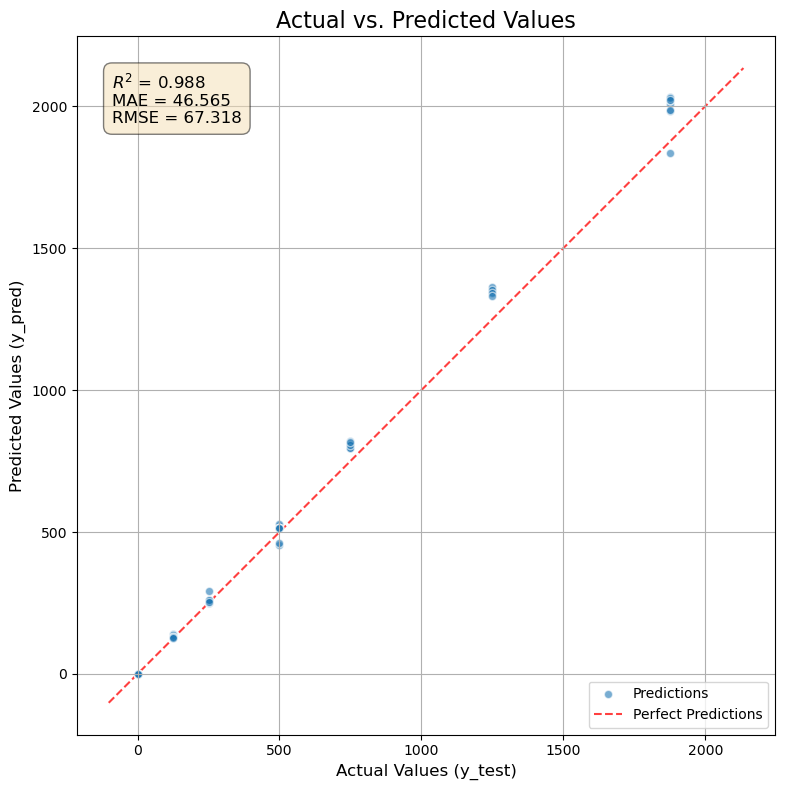

In [8]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the saved model from the file
print(f"Loading model from: {dynamic_filename}")
loaded_model = tf.keras.models.load_model('/Users/andresmr/Documents/Glyphosate_sensor_CFATA/models/'+dynamic_filename)
print("Model loaded successfully.")

# Use the loaded model to make predictions on the test data
y_pred = loaded_model.predict(X_test)

# The output of .predict() is often a 2D array, so we flatten it to a 1D array
y_pred = y_pred.flatten()

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"R-squared (R2): {r2:.3f}")

# 2. Create the plot
fig, ax = plt.subplots(figsize=(8, 8))

# Scatter plot of actual vs. predicted values
ax.scatter(y_test, y_pred, alpha=0.6, edgecolors="w", label='Predictions')

# Add a line for perfect predictions (y=x)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='Perfect Predictions')

# 3. Add metrics to the plot
# Using LaTeX for R^2
metrics_text = (
    f"$R^2$ = {r2:.3f}\n"
    f"MAE = {mae:.3f}\n"
    f"RMSE = {rmse:.3f}"
)
# Place text box in the top-left corner
ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

# 4. Final plot settings
ax.set_xlabel("Actual Values (y_test)", fontsize=12)
ax.set_ylabel("Predicted Values (y_pred)", fontsize=12)
ax.set_title("Actual vs. Predicted Values", fontsize=16)
ax.set_aspect('equal', adjustable='box')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

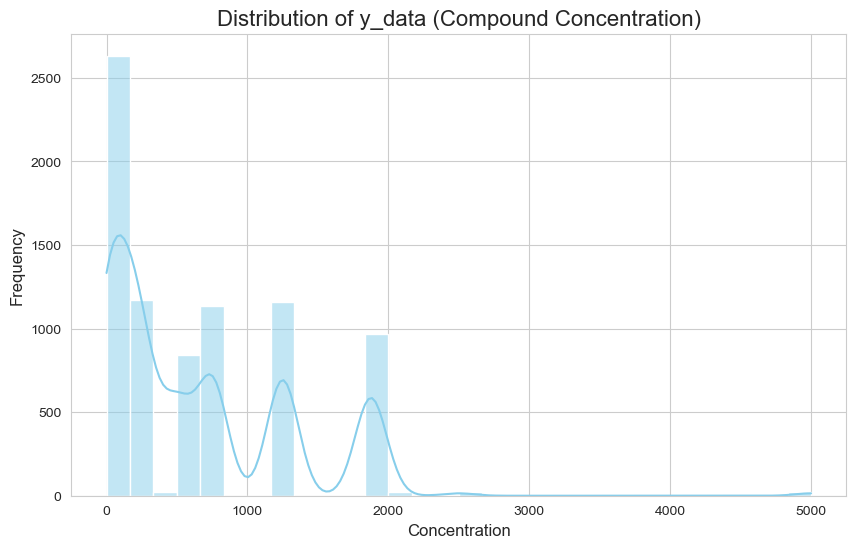

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

y_data_sample = y_data
# ----------------------------------------------------

# Set the style of the plot for better aesthetics
sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(10, 6)) # Set the figure size
# Using a histogram with a Kernel Density Estimate (KDE)
sns.histplot(y_data_sample, kde=True, bins=30, color='skyblue')

# Add titles and labels for clarity
plt.title('Distribution of y_data (Compound Concentration)', fontsize=16)
plt.xlabel('Concentration', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Display the plot 📊
plt.show()

In [ ]:
#!pip install everywhereml>=0.2.12


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\algim\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [23]:
from everywhereml.code_generators.tensorflow import tf_porter

#tf_model, x_train, y_train = get_model()
# tf_porter() requires:
#   1. the neural network model
#   2. the input data (to detect the input dimensions)
#   3. the output labels (to detect the number of classes - if classification)
#
# Passing `instance_name` will create an instance of the model, so you don't have to
# `area_size` is to control how much memory to allocate for the network
# It is a trial-and-error process


#porter = tf_porter(tf_model, entradas_train, salidas_train)
porter = tf_porter(model, entradas_train, salidas_train)
cpp_code = porter.to_cpp(instance_name='glifoNN1', arena_size=10000)

#cpp_code.save('/content/gdrive/My Drive/NNglifosato2/NNmar19')

print(cpp_code)

INFO:tensorflow:Assets written to: C:\Users\algim\AppData\Local\Temp\tmpkmj07hdr\assets


INFO:tensorflow:Assets written to: C:\Users\algim\AppData\Local\Temp\tmpkmj07hdr\assets


#ifndef UUID2187630171792
#define UUID2187630171792

#include <EloquentTinyML.h>
#include <eloquent_tinyml/tensorflow.h>

#ifdef __has_attribute
#define HAVE_ATTRIBUTE(x) __has_attribute(x)
#else
#define HAVE_ATTRIBUTE(x) 0
#endif
#if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))
#define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))
#else
#define DATA_ALIGN_ATTRIBUTE
#endif

#ifndef ARENA_SIZE
#define ARENA_SIZE 10000
#endif

/** model size = 34128 bytes **/
const unsigned char modelData[] DATA_ALIGN_ATTRIBUTE = { 0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x94, 0x00, 0x00, 0x00, 0xec, 0x00, 0x00, 0x00, 0x6c, 0x7e, 0x00, 0x00, 0x7c, 0x7e, 0x00, 0x00, 0xfc, 0x84, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 0x00, 0x00, 0x0a, 0x00, 0x10, 0x00, 0x0c, 0x0